# Определение перспективного тарифа для телеком-компании

## Описание проекта

Заказчик - федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

**Цель**
* Cделать предварительный анализ тарифов и определить какой тариф лучше.

 **Описание тарифов:**
 
Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    минута разговора: 3 рубля
    сообщение: 3 рубля
    1 Гб интернет-трафика: 200 рублей
    
    
Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
  минута разговора: 1 рубль
  сообщение: 1 рубль
  1 Гб интернет-трафика: 150 рублей
 
Описание данных

Таблица users (информация о пользователях):

* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tarif` — название тарифного плана

Таблица calls (информация о звонках):

* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Таблица tariffs (информация о тарифах):

* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Общая информация

In [1]:
# импортируем все необходимые для работы библиотеки
import pandas as pd
import numpy as np
import scipy
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# чтение файла с данными и сохранение в переменную
calls = pd.read_csv('calls.csv')
display(calls.head(10))
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
# Описание столбца продолжительности звонков
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

 <div style="border:solid green 1px; padding: 20px"> 
 Нулями обозначены пропущенные звонки, поэтому их не нужно удалять. Максимальное время звонка (38 минут) является адекватным значением.
</div>

In [3]:
# чтение файла с данными и сохранение в переменную
internet = pd.read_csv('internet.csv', index_col=0)
display(internet.head(10))
internet.info()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [4]:
# Описательная статистика для столбца mb_used
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [5]:
# Находим количество строк со значением mb_used равным 0
internet[internet.mb_used == 0].count()

id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64

<div style="border:solid green 1px; padding: 20px"> 
 Считаем, что значение 0 в столбце mb_used не ошибка. Возможно при подключени к интернету, что-то пошло не так и не удалось подключиться, поэтому запись есть, а трафика нет, либо в определенном месяце человек не использовал интернет трафик.
</div>

In [6]:
# чтение файла с данными и сохранение в переменную
messages = pd.read_csv('messages.csv')
display(messages.head(10))
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [8]:
# чтение файла с данными и сохранение в переменную
tariffs = pd.read_csv('tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
# чтение файла с данными и сохранение в переменную
users = pd.read_csv('users.csv')
display(users.head(10))
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [11]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

<div style="border:solid green 1px; padding: 20px"> 
 Значния в столбце age адекватны. Минимальное - 18 лет, максимальное - 75 лет.
</div>

In [12]:
# Проверяем различное написание одного и того же города, что бы исключить дубликатты
users['city'] = users['city'].str.lower()
users.sort_values(by='city')['city'].unique()

array(['архангельск', 'астрахань', 'балашиха', 'барнаул', 'белгород',
       'брянск', 'владивосток', 'владикавказ', 'владимир', 'волгоград',
       'волжский', 'вологда', 'воронеж', 'грозный', 'екатеринбург',
       'иваново', 'ижевск', 'иркутск', 'казань', 'калининград', 'калуга',
       'кемерово', 'киров', 'кострома', 'краснодар', 'красноярск',
       'курган', 'курск', 'липецк', 'магнитогорск', 'махачкала', 'москва',
       'мурманск', 'набережные челны', 'нижневартовск', 'нижний новгород',
       'нижний тагил', 'новокузнецк', 'новороссийск', 'новосибирск',
       'омск', 'оренбург', 'орёл', 'пенза', 'пермь', 'петрозаводск',
       'подольск', 'ростов-на-дону', 'рязань', 'самара',
       'санкт-петербург', 'саранск', 'саратов', 'севастополь', 'смоленск',
       'сочи', 'ставрополь', 'стерлитамак', 'сургут', 'тамбов', 'тверь',
       'тольятти', 'томск', 'тула', 'тюмень', 'улан-удэ', 'ульяновск',
       'уфа', 'хабаровск', 'химки', 'чебоксары', 'челябинск', 'череповец',
       'чи

In [13]:
# Проверяем наличие дубликатов 
users.duplicated().sum()

0

#### **Вывод**

1. Пропуски отсутствуют
2. Явных ошибок в данных и дубликатов не обнаружено

## Предобработка данных

### Приведите данных к нужным типам

In [14]:
# Изменяем тип данных в столбце call_date в датасете calls c object на datetime64
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y.%m.%d')

In [15]:
# Огруглим значения в столбце duration в большую сторону
calls['duration'] = np.ceil(calls['duration'])
calls['duration'].head()

0     0.0
1     0.0
2     3.0
3    14.0
4     6.0
Name: duration, dtype: float64

In [16]:
# Изменим тип данных в столбце duration с float на int
calls['duration'] = calls['duration'].astype('int')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


In [17]:
# Изменяем тип данных в столбце session_date в датасете internet
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y.%m.%d')

In [18]:
# Изменяем тип данных в столбце message_date в датасете messages
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y.%m.%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [19]:
# Изменяем тип данных в столбце reg_date в датасете users
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y.%m.%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


#### **Вывод**

1. В столбцах со значением даты тип данных с object изменен на datetime64;
2. В столбцаx со значениями использованных минут разговора тип данных изменен с float на int

### Объем израсходованного интернет-трафика по месяцам

In [20]:
internet['internet_date_month'] = internet['session_date'].dt.month_name()

In [21]:
# Группируем данные из датасета internet_income с данными из датасета users
internet_income = internet.merge(users, on ='user_id', how='outer')
internet_income.head()

,id,mb_used,session_date,user_id,internet_date_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,112.95,2018-11-25,1000,November,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,1052.81,2018-09-07,1000,September,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,1197.26,2018-06-25,1000,June,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,550.27,2018-08-22,1000,August,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,302.56,2018-09-24,1000,September,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [22]:
# Находим объем израсходованного интернет-трафика по месяцам
internet_income_group = internet_income.groupby(['user_id','internet_date_month','tariff'],
                                      as_index=False)['mb_used'].sum()
internet_income_group

,user_id,internet_date_month,tariff,mb_used
0,1000,August,ultra,14055.93
1,1000,December,ultra,9817.61
2,1000,July,ultra,14003.64
3,1000,June,ultra,23233.77
4,1000,May,ultra,2253.49
...,...,...,...,...
3198,1498,September,smart,22134.41
3199,1499,December,smart,13055.58
3200,1499,November,smart,17963.31
3201,1499,October,smart,17788.51


/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Consumption mb per month')

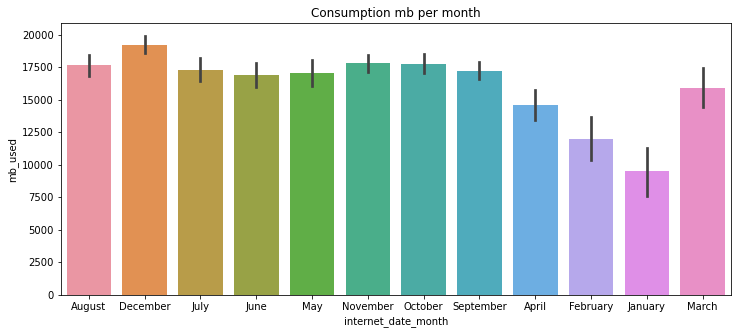

In [28]:
figure = plt.figure(figsize=(12,5))
sns.barplot(internet_income_group['internet_date_month'],internet_income_group['mb_used'])
plt.title('Consumption mb per month')

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [29]:
calls['call_date_month'] = calls['call_date'].dt.month_name()

In [30]:
# Группируем данные из датасета call_income с данными из датасета users
call_income = calls.merge(users, on ='user_id', how='outer')
call_income.head()

,id,call_date,duration,user_id,call_date_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-07-25,0.0,1000,July,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-08-17,0.0,1000,August,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,2018-06-11,3.0,1000,June,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,2018-09-21,14.0,1000,September,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,2018-12-15,6.0,1000,December,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [31]:
# Находим количество сделанных звонков и израсходованных минут разговора по месяцам
call_group = call_income.groupby(['user_id','call_date_month','tariff'],
                                        as_index=False)[['duration']].agg(['sum','count'])
call_group

duration      
                                    sum count
user_id call_date_month tariff               
1000    August          ultra     408.0    52
        December        ultra     333.0    46
        July            ultra     340.0    47
        June            ultra     172.0    43
        May             ultra     159.0    22
...                                 ...   ...
1498    September       smart     471.0    59
1499    December        smart     492.0    69
        November        smart     612.0    74
        October         smart     449.0    68
        September       smart      70.0     9

[3174 rows x 2 columns]

In [32]:
# Таблица такого ввида понадобится при группировке датасеттов для вычесления выручки
call_income_group = call_income.groupby(['user_id','call_date_month','tariff'],
                                        as_index=False)[['duration']].sum()

### Количество отправленных сообщений по месяцам

In [33]:
messages['message_date_month'] = messages['message_date'].dt.month_name()

In [34]:
# Группируем данные из датасета messages с данными из датасета users
messages_income = messages.merge(users, on ='user_id', how='outer')
messages_income.head()

,id,message_date,user_id,message_date_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-06-27,1000,June,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-10-08,1000,October,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,2018-08-04,1000,August,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,2018-06-16,1000,June,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,2018-12-05,1000,December,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [35]:
# Находим количество отправленных сообщений по месяцам
messages_income_group = messages_income.groupby(['user_id', 'message_date_month','tariff'],
                                                as_index=False)['id'].agg('count')
messages_income_group

,user_id,message_date_month,tariff,id
0,1000,August,ultra,81
1,1000,December,ultra,70
2,1000,July,ultra,75
3,1000,June,ultra,60
4,1000,May,ultra,22
...,...,...,...,...
2712,1498,September,smart,44
2713,1499,December,smart,66
2714,1499,November,smart,59
2715,1499,October,smart,48


### Помесячную выручку с каждого пользователя

In [36]:
# Группируем датасеты messages_income_group, call_income_group, internet_income_group
messages_income_group = messages_income_group.rename(
    columns={'message_date_month':'month', 'tariff':'tariff_name'}
)
call_income_group = call_income_group.rename(
    columns={'call_date_month':'month',  'tariff':'tariff_name'}
)
internet_income_group = internet_income_group.rename(
    columns={'internet_date_month':'month',  'tariff':'tariff_name'}
)

incom_per_month = (
    messages_income_group.merge(
        call_income_group,
        how='outer',
        on=['user_id', 'month', 'tariff_name']
    ).merge(
        internet_income_group, 
        how='outer',
        on=['user_id', 'month', 'tariff_name']
    )
)

incom_per_month = incom_per_month.rename(columns={'id':'messages_count', 'duration':'call_duration'})
incom_per_month

,user_id,month,tariff_name,messages_count,call_duration,mb_used
0,1000,August,ultra,81.0,408.0,14055.93
1,1000,December,ultra,70.0,333.0,9817.61
2,1000,July,ultra,75.0,340.0,14003.64
3,1000,June,ultra,60.0,172.0,23233.77
4,1000,May,ultra,22.0,159.0,2253.49
...,...,...,...,...,...,...
3209,1494,December,smart,NaN,418.0,17621.21
3210,1494,November,smart,NaN,411.0,18052.45
3211,1494,October,smart,NaN,354.0,17767.24
3212,1494,September,smart,NaN,501.0,16962.51


In [37]:
# Найдем id пользователей, которые 'потеряшки'
(
    set(users['user_id'].unique())
     - set(messages['user_id'].unique())
    .union(set(calls['user_id'].unique()))
    .union(set(internet['user_id'].unique()))
)

{1128, 1371}

In [38]:
users.query('user_id == 1128 | user_id == 1371')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,омск,Ириней,Трофимов,2018-12-25,smart


In [39]:
# Добавляем две строки с потерянными пользователями
add_row_1 = {'user_id':'1128', 'month':'December', 'tariff_name': 'ultra', 'messages_count': 0, 'call_duration' :0, 
          'mb_used':0}
add_row_2 = {'user_id':'1371', 'month':'December', 'tariff_name': 'smart', 'messages_count': 0, 'call_duration' :0, 
          'mb_used':0}
incom_per_month = incom_per_month.append([add_row_1,add_row_2], ignore_index=True)
incom_per_month

/var/folders/vf/z1gk_tyn2zsf73w6bspmxgjm0000gn/T/ipykernel_36027/1050653143.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  incom_per_month = incom_per_month.append([add_row_1,add_row_2], ignore_index=True)


,user_id,month,tariff_name,messages_count,call_duration,mb_used
0,1000,August,ultra,81.0,408.0,14055.93
1,1000,December,ultra,70.0,333.0,9817.61
2,1000,July,ultra,75.0,340.0,14003.64
3,1000,June,ultra,60.0,172.0,23233.77
4,1000,May,ultra,22.0,159.0,2253.49
...,...,...,...,...,...,...
3211,1494,October,smart,NaN,354.0,17767.24
3212,1494,September,smart,NaN,501.0,16962.51
3213,1476,April,ultra,NaN,NaN,530.78
3214,1128,December,ultra,0.0,0.0,0.00


In [40]:
# Объединим датасет incom_per_mounth с датасетом tariffs 
incom_per_month = incom_per_month.merge(tariffs, on='tariff_name').copy()
incom_per_month

,user_id,month,tariff_name,messages_count,call_duration,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,August,ultra,81.0,408.0,14055.93,1000,30720,3000,1950,150,1,1
1,1000,December,ultra,70.0,333.0,9817.61,1000,30720,3000,1950,150,1,1
2,1000,July,ultra,75.0,340.0,14003.64,1000,30720,3000,1950,150,1,1
3,1000,June,ultra,60.0,172.0,23233.77,1000,30720,3000,1950,150,1,1
4,1000,May,ultra,22.0,159.0,2253.49,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1494,December,smart,NaN,418.0,17621.21,50,15360,500,550,200,3,3
3212,1494,November,smart,NaN,411.0,18052.45,50,15360,500,550,200,3,3
3213,1494,October,smart,NaN,354.0,17767.24,50,15360,500,550,200,3,3
3214,1494,September,smart,NaN,501.0,16962.51,50,15360,500,550,200,3,3


In [41]:
# В столбце появились NaN, это говорит о том, что определенный пользователь в определенный месяц или вообще
# не использовал звонки или смс или интернет трафик, следовательно можно заменить на 0
incom_per_month = incom_per_month.fillna(0)

In [42]:
# В столбцах 'call_duration', 'mb_used', 'messages_count' изменяем тип данных на int
incom_per_month[['call_duration', 'mb_used', 'messages_count']] =(
    incom_per_month[['call_duration', 'mb_used', 'messages_count']].astype('int')
) 
incom_per_month

,user_id,month,tariff_name,messages_count,call_duration,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,August,ultra,81,408,14055,1000,30720,3000,1950,150,1,1
1,1000,December,ultra,70,333,9817,1000,30720,3000,1950,150,1,1
2,1000,July,ultra,75,340,14003,1000,30720,3000,1950,150,1,1
3,1000,June,ultra,60,172,23233,1000,30720,3000,1950,150,1,1
4,1000,May,ultra,22,159,2253,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1494,December,smart,0,418,17621,50,15360,500,550,200,3,3
3212,1494,November,smart,0,411,18052,50,15360,500,550,200,3,3
3213,1494,October,smart,0,354,17767,50,15360,500,550,200,3,3
3214,1494,September,smart,0,501,16962,50,15360,500,550,200,3,3


In [43]:
# Функция для вычисления израсходованных минут
def count_message(row):
    a = row.messages_count - row.messages_included
    if a < 0:
        return(0)
    
    return(a*row.rub_per_message)
    
incom_per_month['message_price'] = incom_per_month.apply(count_message, axis=1)  

In [44]:
# Функция для вычисления израсходованных минут на звонки
def count_call_duration(row):
    a = row.call_duration - row.minutes_included
    if a < 0:
        return(0)   
    return(a*row.rub_per_minute)
    
incom_per_month['call_price'] = incom_per_month.apply(count_call_duration, axis=1)

In [45]:
# Функция для вычисления израсходованного интернет трафика
def count_internet(row):
    a = row.mb_used - row.mb_per_month_included
    if a < 0:
        return(0)
    return(a)
    
incom_per_month['internet_price_mb'] = incom_per_month.apply(count_internet, axis=1)

In [46]:
# Рассчитаем стоимость интернет трафика, превышающего норму предусмотренную тарифом
incom_per_month['internet_price_GB'] = (
    np.ceil((incom_per_month['internet_price_mb'] / 1024)).astype('int')
)
incom_per_month['internet_price_GB'] = incom_per_month['internet_price_GB']*incom_per_month['rub_per_gb']
incom_per_month

,user_id,month,tariff_name,messages_count,call_duration,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,message_price,call_price,internet_price_mb,internet_price_GB
0,1000,August,ultra,81,408,14055,1000,30720,3000,1950,150,1,1,0,0,0,0
1,1000,December,ultra,70,333,9817,1000,30720,3000,1950,150,1,1,0,0,0,0
2,1000,July,ultra,75,340,14003,1000,30720,3000,1950,150,1,1,0,0,0,0
3,1000,June,ultra,60,172,23233,1000,30720,3000,1950,150,1,1,0,0,0,0
4,1000,May,ultra,22,159,2253,1000,30720,3000,1950,150,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1494,December,smart,0,418,17621,50,15360,500,550,200,3,3,0,0,2261,600
3212,1494,November,smart,0,411,18052,50,15360,500,550,200,3,3,0,0,2692,600
3213,1494,October,smart,0,354,17767,50,15360,500,550,200,3,3,0,0,2407,600
3214,1494,September,smart,0,501,16962,50,15360,500,550,200,3,3,0,3,1602,400


In [48]:
# Найдем помесячеую выручку с каждого пользователя
incom_per_month['full_fee'] = (
    (incom_per_month['call_price']+
    incom_per_month['message_price']+
    incom_per_month['internet_price_GB']+
    incom_per_month['rub_monthly_fee']) 
)
incom_per_month

,user_id,month,tariff_name,messages_count,call_duration,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,message_price,call_price,internet_price_mb,internet_price_GB,full_fee
0,1000,August,ultra,81,408,14055,1000,30720,3000,1950,150,1,1,0,0,0,0,1950
1,1000,December,ultra,70,333,9817,1000,30720,3000,1950,150,1,1,0,0,0,0,1950
2,1000,July,ultra,75,340,14003,1000,30720,3000,1950,150,1,1,0,0,0,0,1950
3,1000,June,ultra,60,172,23233,1000,30720,3000,1950,150,1,1,0,0,0,0,1950
4,1000,May,ultra,22,159,2253,1000,30720,3000,1950,150,1,1,0,0,0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1494,December,smart,0,418,17621,50,15360,500,550,200,3,3,0,0,2261,600,1150
3212,1494,November,smart,0,411,18052,50,15360,500,550,200,3,3,0,0,2692,600,1150
3213,1494,October,smart,0,354,17767,50,15360,500,550,200,3,3,0,0,2407,600,1150
3214,1494,September,smart,0,501,16962,50,15360,500,550,200,3,3,0,3,1602,400,953


#### **Вывод**:
Нашли:
1. Объем израсходованного интернет трафика трафика для пользователей по месяцам
2. Количество и продолжительность звонков для пользователей по месяцам
3. Количество отправленных сообщений для пользователей по месяцам
4. Рассчитали выручку с каждого пользователя с учетом его тарифного плана и израсходованных минут, звонков и интернет трафика в месяц. 

## Анализ данных

<div style="border:solid green 1px; padding: 20px"> 
 Поскольку выборки пользователей разных тарифов не зависят друг от друга, то их объем может отличаться. Следовательно у нас 149 пользователей тарифа smart и 309 пользователя тарифа ultra. 2 пользователя из предоставленной выборки не использовали смс, звонки и интернет трафик, поэтому при группировки данных в один датасет они не учитывались.
</div>


In [49]:
# Выбираем клиентов оператора с тарифным планом smart
incom_per_month_smart = incom_per_month.query('tariff_name == "smart"')
incom_per_month_smart

,user_id,month,tariff_name,messages_count,call_duration,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,message_price,call_price,internet_price_mb,internet_price_GB,full_fee
986,1002,August,smart,13,289,20319,50,15360,500,550,200,3,3,0,0,4959,1000,1550
987,1002,December,smart,12,236,18113,50,15360,500,550,200,3,3,0,0,2753,600,1150
988,1002,July,smart,11,214,17580,50,15360,500,550,200,3,3,0,0,2220,600,1150
989,1002,June,smart,4,117,10856,50,15360,500,550,200,3,3,0,0,0,0,550
990,1002,November,smart,16,243,18587,50,15360,500,550,200,3,3,0,0,3227,800,1350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1494,December,smart,0,418,17621,50,15360,500,550,200,3,3,0,0,2261,600,1150
3212,1494,November,smart,0,411,18052,50,15360,500,550,200,3,3,0,0,2692,600,1150
3213,1494,October,smart,0,354,17767,50,15360,500,550,200,3,3,0,0,2407,600,1150
3214,1494,September,smart,0,501,16962,50,15360,500,550,200,3,3,0,3,1602,400,953


In [50]:
# Находим среднеее количество сообщений, минут звонком и интернет трафика необходимое клиентам smart в месяц
incom_per_month_smart[['messages_count', 'call_duration','mb_used']].mean()

messages_count       33.369058
call_duration       417.747534
mb_used           16200.613004
dtype: float64

Клиентам тарифа smart в среднем необходимо 33 сообщения, 417 минуты звонков и 16230 мб интернет трафика в месяц.

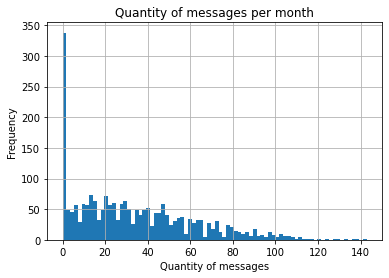

In [57]:
# Строим гистограмму распределения количества сообщений 
ax = incom_per_month_smart['messages_count'].hist(bins=80)
plt.title('Quantity of messages per month')
ax.set_xlabel('Quantity of messages')
ax.set_ylabel('Frequency');

Распределение количества сообщений не является нормальным.

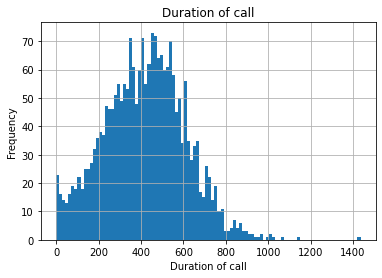

In [58]:
# Строим гистограмму распределения для продолжительности звонков 
ax = incom_per_month_smart['call_duration'].hist(bins=100)
incom_per_month_smart['call_duration'].describe()
plt.title('Duration of call')
ax.set_xlabel('Duration of call')
ax.set_ylabel('Frequency');

Распределение продолжительности звонков по месяцам близко к нормальному. Поскольку медиана немного больше среднего, то можно сказать, что датасет скошен немного влево.

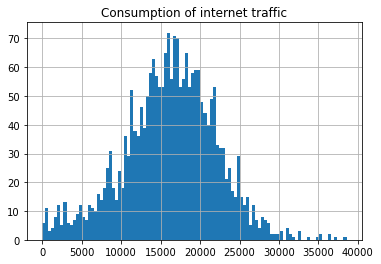

In [59]:
# Строим гистограмму распределения для использованного интернет трафика 
incom_per_month_smart['mb_used'].hist(bins=100);
incom_per_month_smart['mb_used'].describe()
plt.title('Consumption of internet traffic')
ax.set_xlabel('Internet traffic')
ax.set_ylabel('Frequency');

Распределение продолжительности звонков близко к нормальному. Поскольку медиана немного больше среднего, то можно сказать, что датасет скошен немного влево.

In [60]:
# Рассчитаем дисперсию для клиентов smart
variance_smart_messages = np.var(incom_per_month_smart['messages_count'], ddof=1)
variance_smart_call = np.var(incom_per_month_smart['call_duration'], ddof=1)
variance_smart_mb = np.var(incom_per_month_smart['mb_used'], ddof=1)
print(f'''Дисперсия по количеству сообщений: {variance_smart_messages},
Десперсия по продолжительности звонков: {variance_smart_call},
Деспервия по количеству использованного интернет трафика: {variance_smart_mb}''')

Дисперсия по количеству сообщений: 796.9552557301,
Десперсия по продолжительности звонков: 36281.393836444564,
Деспервия по количеству использованного интернет трафика: 34564879.073585846


In [61]:
# Рассчитаем стандартное отклонение для клиентов smart
std_smart_messages = np.std(incom_per_month_smart['messages_count'], ddof=1)
std_smart_call = np.std(incom_per_month_smart['call_duration'], ddof=1)
std_smart_mb = np.std(incom_per_month_smart['mb_used'], ddof=1)
print(f'''Стандартное отклонение для количества сообщений: {std_smart_messages},
Стандартное отклонение для продолжительности звонков: {std_smart_call},
Стандартное отклонение для использованного интернет трафика: {std_smart_mb}''')

Стандартное отклонение для количества сообщений: 28.230395954185624,
Стандартное отклонение для продолжительности звонков: 190.47675405792845,
Стандартное отклонение для использованного интернет трафика: 5879.190341670002


На величину стандартного отклонения отличаются все индивидуальные значения от среднего значения в выборке.

In [62]:
column = ['messages_count', 'call_duration', 'mb_used']
for i in incom_per_month_smart.columns:
    if i in column:
         display (i, incom_per_month_smart[i].agg(['mean','std','var']))

'messages_count'

mean     33.369058
std      28.230396
var     796.955256
Name: messages_count, dtype: float64

'call_duration'

mean      417.747534
std       190.476754
var     36281.393836
Name: call_duration, dtype: float64

'mb_used'

mean    1.620061e+04
std     5.879190e+03
var     3.456488e+07
Name: mb_used, dtype: float64

In [63]:
# Выбрали клиентов оператора с тарифным планом ultra
incom_per_month_ultra = incom_per_month.query('tariff_name == "ultra"')

In [64]:
# Находим среднеее количество сообщений, минут звонком и интернет трафика необходимое клиентам ultra в месяц
incom_per_month_ultra[['messages_count', 'call_duration','mb_used']].mean()

messages_count       49.313387
call_duration       526.089249
mb_used           19448.582150
dtype: float64

Клиентам тарифа ultra в среднем необходимо 49 сообщение, 527 минут звонков и 19487 мб интернет трафика в месяц

count    986.000000
mean      49.313387
std       47.806040
min        0.000000
25%        6.000000
50%       38.000000
75%       78.750000
max      224.000000
Name: messages_count, dtype: float64

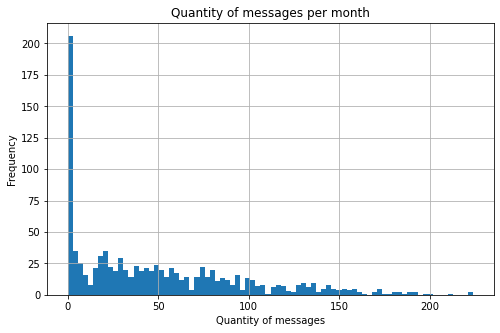

In [69]:
plt.figure(figsize=(8,5))
ax = incom_per_month_ultra['messages_count'].hist(bins=80)
plt.title('Quantity of messages per month')
ax.set_xlabel('Quantity of messages')
ax.set_ylabel('Frequency');
incom_per_month_ultra['messages_count'].describe()

Распределение количества сообщений для пользователей тарифа "Ультра" не является нормальным.

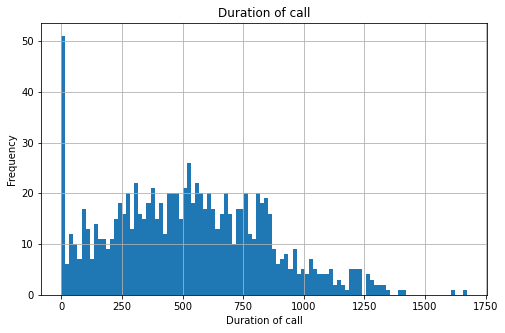

In [70]:
plt.figure(figsize=(8,5))
ax = incom_per_month_ultra['call_duration'].hist(bins=100)
incom_per_month_ultra['call_duration'].describe()
incom_per_month_smart['call_duration'].describe()
plt.title('Duration of call')
ax.set_xlabel('Duration of call')
ax.set_ylabel('Frequency');

Медианное значение меньше среднего значения, датасет скошен влево. Распределение похоже на нормальное.

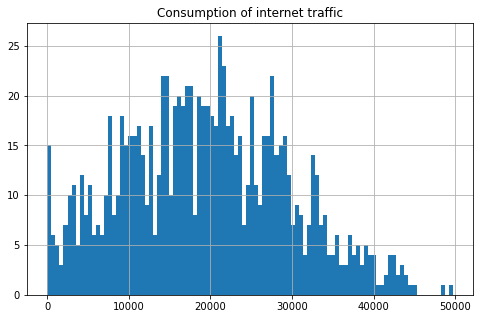

In [71]:
plt.figure(figsize=(8,5))
incom_per_month_ultra['mb_used'].hist(bins=100)
incom_per_month_ultra['mb_used'].describe()
plt.title('Consumption of internet traffic')
ax.set_xlabel('Internet traffic')
ax.set_ylabel('Frequency');

Медианное значение меньше среднего, датасет скошен вправо. Распределение нормальное.

In [72]:
column = ['messages_count', 'call_duration', 'mb_used']
for i in incom_per_month_ultra.columns:
    if i in column:
         display (i, incom_per_month_smart[i].agg(['mean','std','var']))

'messages_count'

mean     33.369058
std      28.230396
var     796.955256
Name: messages_count, dtype: float64

'call_duration'

mean      417.747534
std       190.476754
var     36281.393836
Name: call_duration, dtype: float64

'mb_used'

mean    1.620061e+04
std     5.879190e+03
var     3.456488e+07
Name: mb_used, dtype: float64

На величину стандартного отклонения отличаются все индивидуальные значения от среднего значения в выборке.

In [77]:
incom_per_month['month'].unique()

array(['August', 'December', 'July', 'June', 'May', 'November', 'October',
       'September', 'April', 'March', 'February', 'January'], dtype=object)

In [83]:
list=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
     'October', 'November', 'December']

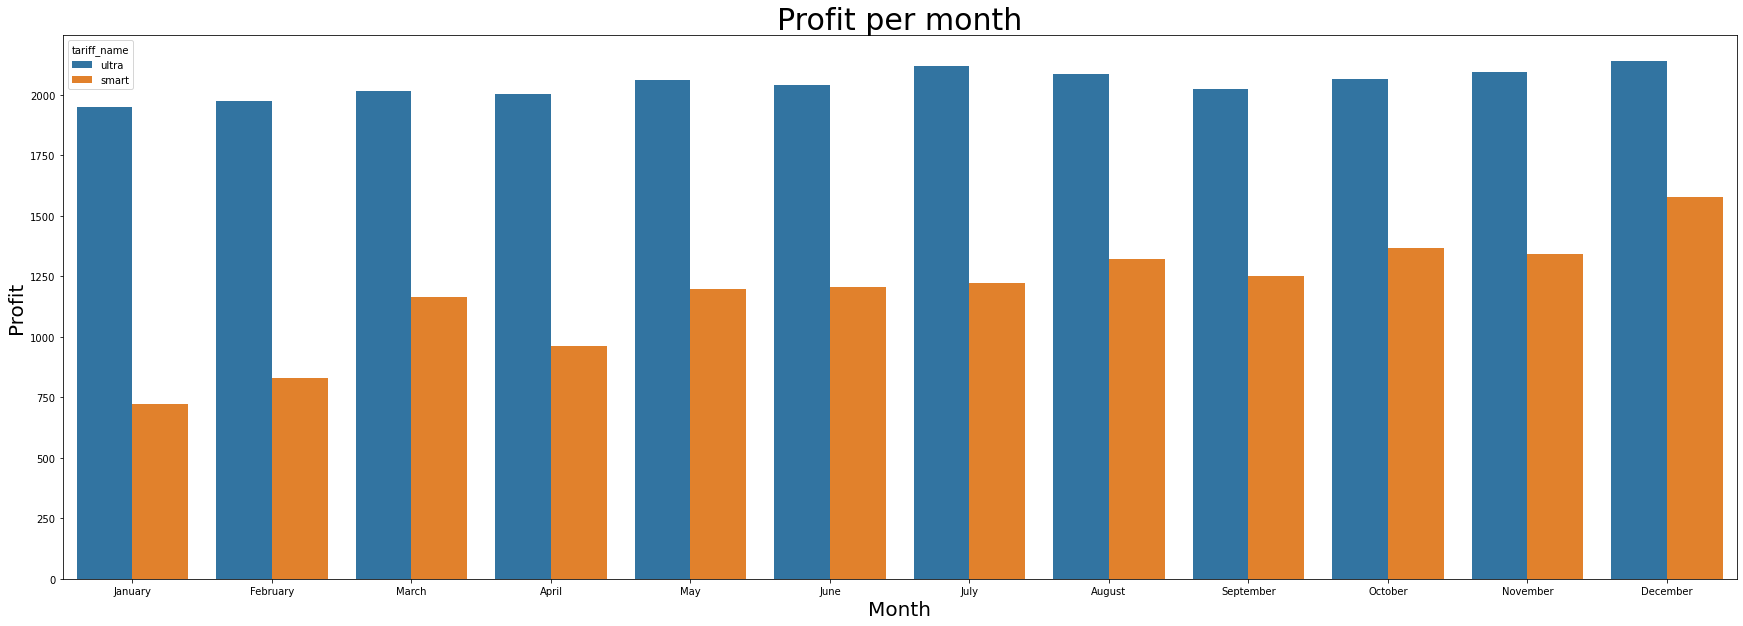

In [84]:
fig = plt.figure(figsize=(30, 10))
sns.barplot(x='month', y ='full_fee', hue="tariff_name",
           data=incom_per_month, ci=0, order=list), 
plt.title('Profit per month', fontsize = 30)
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Profit', fontsize = 20)
plt.show()

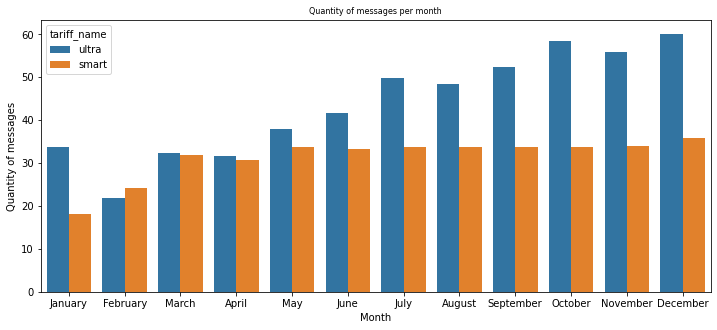

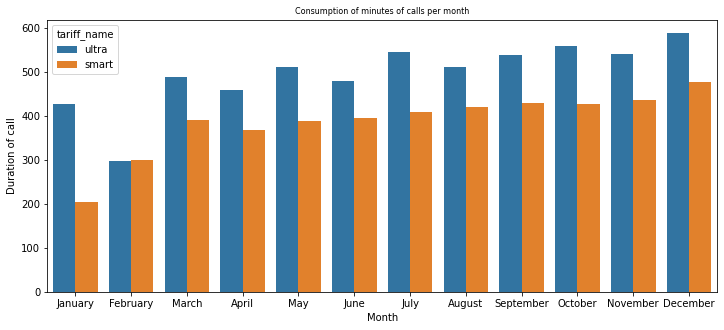

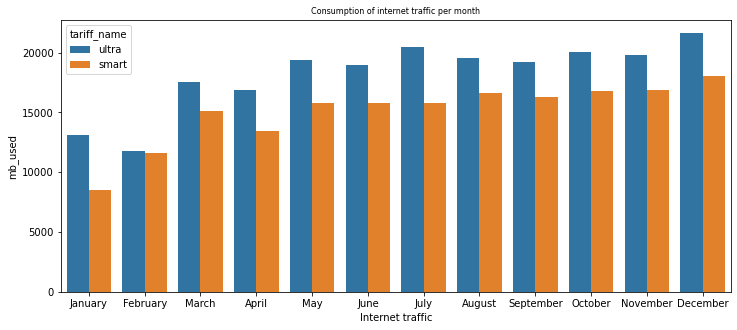

In [86]:
y_name = ['messages_count', 'call_duration', 'mb_used']
for i in y_name:
    fig = plt.figure(figsize=(12, 5))
    sns.barplot(x='month', y =i, hue="tariff_name",
           data=incom_per_month, ci=0, order=list)
    if i == 'messages_count':
        plt.title('Quantity of messages per month', fontsize = 8)
        plt.xlabel('Month', fontsize = 10)
        plt.ylabel('Quantity of messages', fontsize = 10)
        plt.show()
    if i == 'call_duration':
        plt.title('Consumption of minutes of calls per month', fontsize = 8)
        plt.xlabel('Month', fontsize = 10)
        plt.ylabel('Duration of call', fontsize = 10)
        plt.show()
    if i == 'mb_used':
        plt.title('Consumption of internet traffic per month', fontsize = 8)
        plt.xlabel('Internet traffic', fontsize = 10)
        plt.show()

#### **Вывод**

Для пользователей тарифа "Ультра" значение дисперсий и стандартного отклонения превышают те же значения для пользователей тарифа "Смарт". Это отражается на гистограммах. Для пользователей двух тарифов распределение количества сообщений не является нормальным, а распределение использованного интернет трафика и звонков близко к нормальному.

Пользователи тарифа "Ультра" тратят больший объем каждой услуги в месяц, что отражено на графиках. Выручка с пользователей тарифа "Ультра" превышают выручку с пользователей тарифа "Смарт" по всем месяцам в течение года.

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

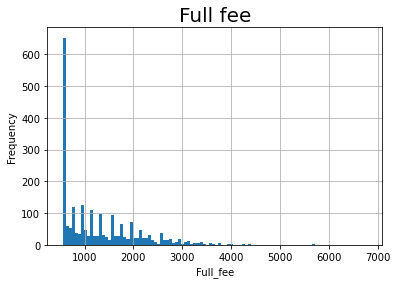

<Figure size 864x720 with 0 Axes>

In [108]:
ax = incom_per_month_smart['full_fee'].hist(bins=100);
plt.figure(figsize=(12,10));
ax.set_title('Full fee', fontsize=20);
ax.set_xlabel('Full_fee');
ax.set_ylabel('Frequency');

**Формулируем нулевую гипотезу**

(Н0): средняя выручка от пользователей тарифа «Ультра» и "Смарт" равны между собой.

**Соответственно альтернативная гипотеза**

(Н1): средняя выручка от пользователей тарифа «Ультра» и "Смарт" не равны между собой.
 
Проверяем первую гипотезу.

In [96]:
sample_1 = incom_per_month_smart['full_fee']
sample_2 = incom_per_month_ultra['full_fee']
alpha = .05
results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.927011394420941e-250
Отвергаем нулевую гипотезу


Вывод: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Что бы ответить на вопрос какой тариф лучше, посмотрим выборочное среднее дохода от пользователей разных тарифов и найдем медианное значение.

In [97]:
mean_income_smart = incom_per_month_smart['full_fee'].mean()
mean_income_ultra = incom_per_month_ultra['full_fee'].mean()
print(mean_income_smart, mean_income_ultra)

1289.6417040358745 2070.030425963489


In [98]:
mean_income_smart = incom_per_month_smart['full_fee'].median()
mean_income_ultra = incom_per_month_ultra['full_fee'].median()
print(mean_income_smart, mean_income_ultra)

1021.0 1950.0


Исходя из полученного выборочного среднего дохода (если можно делать выводы основываясь только на этих данных)
для оператора более выгодным является тариф "Ультра", так как данный тариф приносит больше дохода.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Но - средняя выручка для пользоваттелей из Москвы равна средней выручке для пользователей из других регионов.

Н1 - средняя выручка для пользоваттелей из Москвы отличается от средней выручки для пользователей из других регионов.

In [99]:
# добавили в датасет users колонку 
incom_per_month = (incom_per_month
        .merge(users,
        how='inner',
        on=['user_id']
)).copy()
incom_per_month

,user_id,month,tariff_name,messages_count,call_duration,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,...,internet_price_mb,internet_price_GB,full_fee,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,August,ultra,81,408,14055,1000,30720,3000,1950,...,0,0,1950,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,December,ultra,70,333,9817,1000,30720,3000,1950,...,0,0,1950,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,July,ultra,75,340,14003,1000,30720,3000,1950,...,0,0,1950,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,June,ultra,60,172,23233,1000,30720,3000,1950,...,0,0,1950,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,May,ultra,22,159,2253,1000,30720,3000,1950,...,0,0,1950,52,NaN,краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1494,August,smart,0,262,6590,50,15360,500,550,...,0,0,550,62,NaN,омск,Ренат,Андропов,2018-08-17,smart
3210,1494,December,smart,0,418,17621,50,15360,500,550,...,2261,600,1150,62,NaN,омск,Ренат,Андропов,2018-08-17,smart
3211,1494,November,smart,0,411,18052,50,15360,500,550,...,2692,600,1150,62,NaN,омск,Ренат,Андропов,2018-08-17,smart
3212,1494,October,smart,0,354,17767,50,15360,500,550,...,2407,600,1150,62,NaN,омск,Ренат,Андропов,2018-08-17,smart


In [100]:
sample_1 = incom_per_month.query('city == "москва"')['full_fee']
sample_2 = incom_per_month.query('city != "москва"')['full_fee']
alpha = 0.05
results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Вывод: Отвергнуть нулевую гипотезу нельзя.

## Вывод

1. Уровень дохода со среднего пользователя тарифа "Смарт" составляет 1021 рубля в месяц, а со среднего пользователя тарифа 'Ультра' 1950 рубля в месяц.
2. Средний пользователь тарифа 'Ультра' в месяц израсходует 49 смс, 526 минут разговора, 19449 мб интернет трафика, а средний пользователь тарифа "Смарт"  33 сообщения, 418 минут разговора и 16200 мб интернет трафика.
3. Средний пользователь тарифа "Смарт" тратит больше интернет трафика, чем предусматривает его тариф.
4. Средняя выручка для пользоваттелей из Москвы отличается от средней выручки для пользователей из других регионов.


Более выгодно рекламировать тариф 'Ультра', так как прибыль от него больше. 

In [101]:
print ('Кол-во клентов покинувших компанию за год', users.churn_date.notna().sum())

print ('Кол-во клентов покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах',
       users.query('churn_date > "2018-09-25"').churn_date.notna().sum()
      )
print ('%  от общего кол-ва всех клиентов, покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах',
    (users.query('churn_date > "2018-09-25"').churn_date.notna().sum()/users.churn_date.notna().sum()*100).round(1)
)

print ('Распределение оттока клиентов на тарифах за посл. 4 мес. 2018 г.')
users.query('churn_date > "2018-09-25"').groupby('tariff')['churn_date'].count()

Кол-во клентов покинувших компанию за год 38
Кол-во клентов покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах 35
%  от общего кол-ва всех клиентов, покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах 92.1
Распределение оттока клиентов на тарифах за посл. 4 мес. 2018 г.


tariff
smart    22
ultra    13
Name: churn_date, dtype: int64

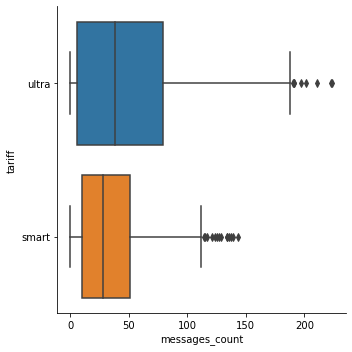

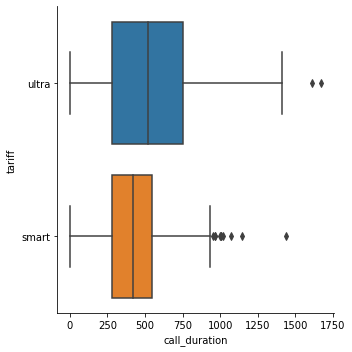

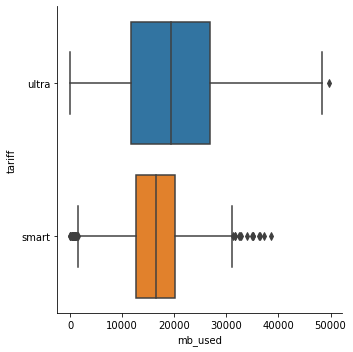

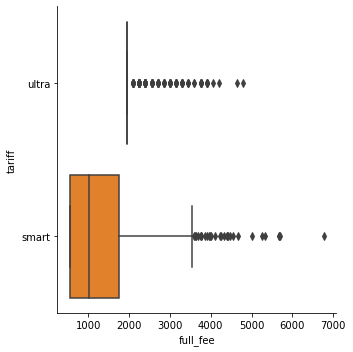

In [102]:
for column in ['messages_count', 'call_duration', 'mb_used', 'full_fee']:    
    sns.catplot(y='tariff', x=column, kind="box", data=incom_per_month, orient='h')